### Reproducting figure 7 in Acceleration of the Solar System from Gaia astrometry

In [2]:
import jax 
import jax.numpy as jnp
import numpy as np
from src.models.vsh_model import*
import pandas as pd
from src.models.configuration import*
from src.data.data_utils import*
import gc

/root/Document/Gaia_Project/mem97/gaia_venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Load data
df = load_filtered_qso_df()
angles, obs, error = config_data(df)

Separating data in to upper and lower plane ($\delta > 0$ and $\delta<0$ respectivelly)

In [4]:
alpha = angles[0]
delta = angles[1]

# Upper plane
mask_upper = delta>=0
ra_upper = alpha[mask_upper]
dec_upper = delta[mask_upper]

angles_upper = np.stack([ra_upper, dec_upper])
obs_upper = obs[:, mask_upper]
error_upper = error[:, mask_upper]

# Lower plane
mask_lower = delta<0
ra_lower = alpha[mask_lower]
dec_lower = delta[mask_lower]

angles_lower = np.stack([ra_lower, dec_lower])
obs_lower = obs[:, mask_lower]
error_lower = error[:, mask_lower]

In [5]:
# Quick assert test
assert len(angles_upper[0]) == len(obs_upper[0])
assert len(obs_upper[0]) == len(error_upper[0])
assert len(angles_lower[0]) == len(obs_lower[0])
assert len(obs_lower[0]) == len(error_lower[0])

# Use HMC Sampling

In [6]:
from numpyro.infer import MCMC, NUTS
import numpyro.distributions as dist
from numpyro.distributions import transforms
import matplotlib.pyplot as plt

In [7]:
def chi2_jit(angles, obs, error, theta, lmax):
    return least_square(angles, obs, error, theta, lmax=lmax, grid=False)
chi2_jit = jit(chi2_jit, static_argnames=['lmax'])


def model_for_HMC(angles, obs, error, lmax):
    total_params = count_vsh_coeffs(lmax)
    
    # Prior on all VSH coefficients (both toroidal and spheroidal)
    theta = numpyro.sample("theta", dist.Uniform(-.01, .01).expand([total_params]))
    # Least-squares residuals: we assume Gaussian-distributed residuals
    chi2_val = chi2_jit(angles, obs, error, theta, lmax=lmax)

    # The log-likelihood is proportional to -0.5*chi^2
    numpyro.factor("likelihood", -0.5*chi2_val)

n_s = 4000 # number of samples
n_warmup = 2000 #  number of warmups 
n_chains = 4 # numbe of chains

In [8]:
rng_key = jax.random.key(0)

kernel = NUTS(model_for_HMC, target_accept_prob=0.75) # this is to make sure acceptance does not exceed 90%
mcmc = MCMC(kernel, num_warmup=n_warmup, num_samples=n_s, num_chains=n_chains, progress_bar=True)
mcmc.run(rng_key, angles = angles_upper, obs = obs_upper, error = error_upper, lmax=10)
ps = mcmc.get_samples()


/tmp/ipykernel_31748/3895959959.py:4: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(kernel, num_warmup=n_warmup, num_samples=n_s, num_chains=n_chains, progress_bar=True)
warmup:   0%|          | 8/6000 [05:47<72:19:27, 43.45s/it, 127 steps of size 1.48e-01. acc. prob=0.58]


KeyboardInterrupt: 

### Upper Panel:

In [ ]:
max_ite = 10

In [ ]:
rng_key = jax.random.key(0)

kernel = NUTS(model_for_HMC, target_accept_prob=0.75) # this is to make sure acceptance does not exceed 90%

posterior_samples_upper = [] # collect posterior samples based on l
for l in range(1, max_ite + 1):
    print(f'l = {l}')
    # Run sampling algoeithm (HMC)
    mcmc = MCMC(kernel, num_warmup=n_warmup, num_samples=n_s, num_chains=n_chains, progress_bar=True)
    mcmc.run(rng_key, angles = angles_upper, obs = obs_upper, error = error_upper, lmax=l)
    ps = mcmc.get_samples()
    posterior_samples_upper.append(ps)
    
    # Free memory after each iteration
    del mcmc
    gc.collect()
    jax.clear_caches()

### Lower Panel:

In [ ]:
posterior_samples_lower = [] # collect posterior samples based on l
for l in range(1, max_ite + 1):
    print(f'l = {l}')
    # Run sampling algoeithm (HMC)
    mcmc = MCMC(kernel, num_warmup=n_warmup, num_samples=n_s, num_chains=n_chains, progress_bar=True)
    mcmc.run(rng_key, angles = angles_lower, obs = obs_lower, error = error_lower, lmax=l)
    ps = mcmc.get_samples()
    posterior_samples_lower.append(ps)
    
    # Free memory after each iteration
    del mcmc
    gc.collect()
    jax.clear_caches()

In [ ]:
# Collecting coefficients and their respective errors

# For upper panel:
coef_pred_up = [jnp.mean(ps['theta'], axis=0) for ps in posterior_samples_upper]
std_pred_up = [jnp.std(ps['theta'], axis=0) for ps in posterior_samples_upper]

# For lower panel:
coef_pred_low = [jnp.mean(ps['theta'], axis=0) for ps in posterior_samples_lower]
std_pred_low = [jnp.std(ps['theta'], axis=0) for ps in posterior_samples_lower]

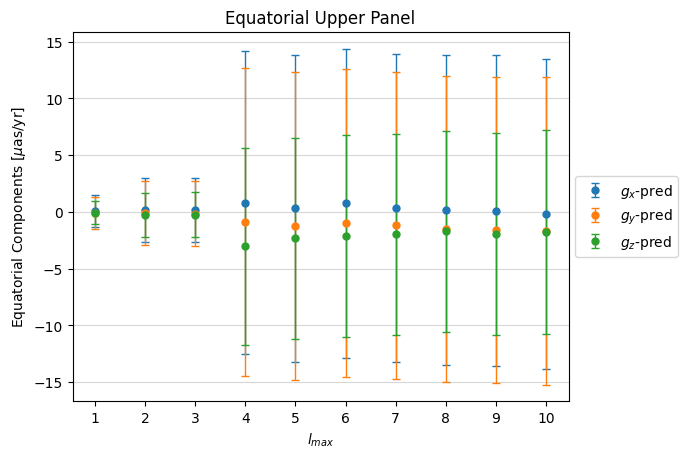

In [ ]:
lmax_values = [1,2,3,4,5,6,7,8,9,10]

C0 = np.sqrt(8*np.pi/3)/1000
C1 = np.sqrt(4*np.pi/3)/1000

# Upper panel:
gz_up, gz_error_up = [coef_pred_up[z][1]/C0 for z in range(0, max_ite)], [std_pred_up[z][1]/C0 for z in range(0,max_ite)]
gx_up, gx_error_up = [-coef_pred_up[x][4]/C1 for x in range(0, max_ite)], [std_pred_up[x][4]/C1 for x in range(0,max_ite)]
gy_up, gy_error_up = [coef_pred_up[y][5]/C1 for y in range(0,max_ite)], [std_pred_up[y][5]/C1 for y in range(0,max_ite)]

plt.figure(figsize=(6.5, 4))  
plt.errorbar(lmax_values, gx_up, yerr=gx_error_up, fmt='o', capsize=3, markersize=5, elinewidth=1, label=r'$g_x$-pred')
plt.errorbar(lmax_values, gy_up, yerr=gy_error_up, fmt='o', capsize=3, markersize=5, elinewidth=1, label=r'$g_y$-pred')
plt.errorbar(lmax_values, gz_up, yerr=gz_error_up, fmt='o', capsize=3, markersize=5, elinewidth=1, label=r'$g_z$-pred')

#plt.title("Equatorial Upper Panel")
plt.xlabel(r'$l_{max}$')
plt.ylabel(r'Equatorial Components [$\mu$as/yr]')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks(lmax_values)
plt.savefig("plots/main_plots/upper_plane.png", dpi=300, bbox_inches='tight')
plt.grid(axis='y', alpha=0.5)
plt.show()

# Lower panel:
gz_low, gz_error_low = [coef_pred_low[z][1]/C0 for z in range(0,max_ite)], [std_pred_low[z][1]/C0 for z in range(0,max_ite)]
gx_low, gx_error_low = [-coef_pred_low[x][4]/C1 for x in range(0,max_ite)], [std_pred_low[x][4]/C1 for x in range(0,max_ite)]
gy_low, gy_error_low = [coef_pred_low[y][5]/C1 for y in range(0,8)], [std_pred_low[y][5]/C1 for y in range(0,8)]

plt.figure(figsize=(6.5, 4))  
plt.errorbar(lmax_values, gx_low, yerr=gx_error_low, fmt='o', capsize=3, markersize=5, elinewidth=1, label=r'$g_x$-pred')
plt.errorbar(lmax_values, gy_low, yerr=gy_error_low, fmt='o', capsize=3, markersize=5, elinewidth=1, label=r'$g_y$-pred')
plt.errorbar(lmax_values, gz_low, yerr=gz_error_low, fmt='o', capsize=3, markersize=5, elinewidth=1, label=r'$g_z$-pred')

#plt.title("Equatorial Upper Panel")
plt.xlabel(r'$l_{max}$')
plt.ylabel(r'Equatorial Components [$\mu$as/yr]')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks(lmax_values)
plt.savefig("plots/main_plots/lower_plane.png", dpi=300, bbox_inches='tight')
plt.grid(axis='y', alpha=0.5)
plt.show()